In [1]:
from multiConceptPipeline import MultiPrompt2PromptPipeline
import torch 
import numpy as np
from attentionControlMulti import AttentionSwap
from utils import view_images


In [2]:
# 基础模型位置
model_path = "/work/imc_lab/ld_xu/stable-diffusion-v1-4"


## multiConceptPipeline相关配置代码 主要是自己改写的pipeline

In [3]:
# custom模型位置
custom_path = "/home/ld_xu/myproject/multi/cat_wooden_pot/500"
device = torch.device('cuda:2') if torch.cuda.is_available() else torch.device('cpu')
# 加载custom模型的参数
pipe = MultiPrompt2PromptPipeline.from_pretrained(model_path).to(device)
pipe.load_textual_inversion(custom_path, weight_name="_new1_.bin")
pipe.load_textual_inversion(custom_path, weight_name="_new2_.bin")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/home/ld_xu/myproject/diffusers/src/diffusers/models/lora.py:300: FutureWarning: `LoRACompatibleConv` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleConv` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleConv", "1.0.0", deprecation_message)
/home/ld_xu/myproject/diffusers/src/diffusers/models/lora.py:387: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)


In [ ]:
# 配置随机种子
g_cpu = torch.Generator().manual_seed(5837)

----------------------------------------------------------------------------------------------------------
Successfull to load the Custom Diffusion Modle Weight from file:/home/ld_xu/myproject/multi/cat_wooden_pot/500
----------------------------------------------------------------------------------------------------------


/home/ld_xu/myproject/diffusers/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:293: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
/home/ld_xu/myproject/multiConcept/multiConcept/multiConceptPipeline.py:68: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channels_latents = self.unet.in_channels


  0%|          | 0/50 [00:00<?, ?it/s]

/home/ld_xu/myproject/diffusers/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:567: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


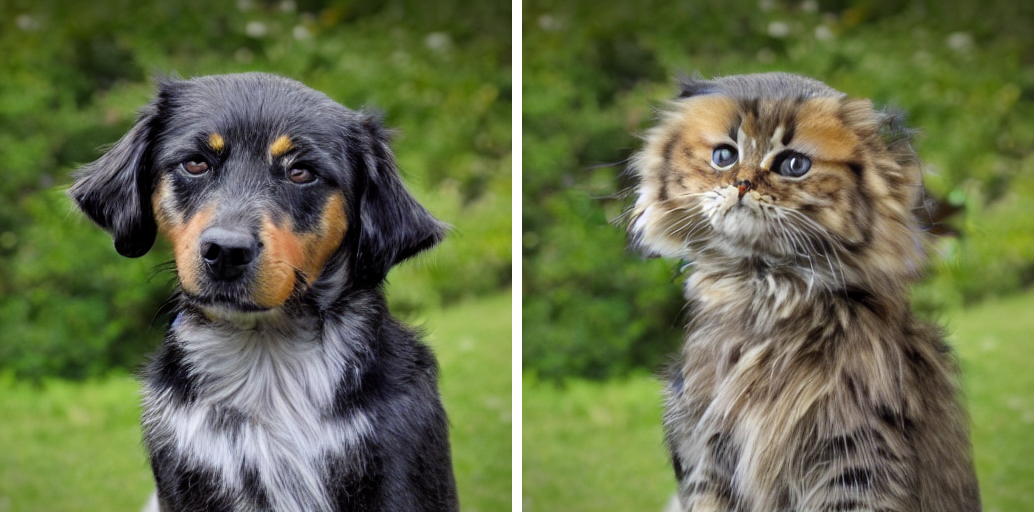

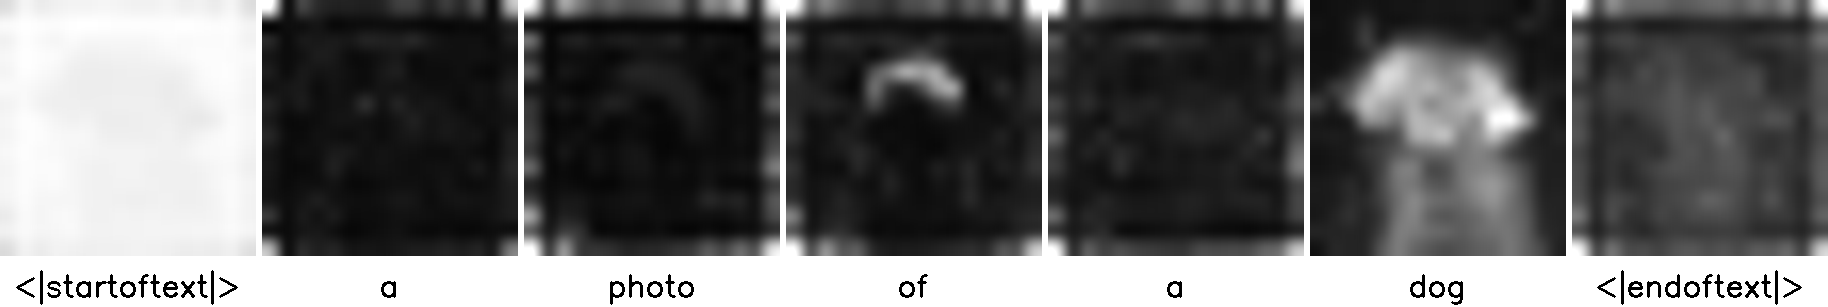

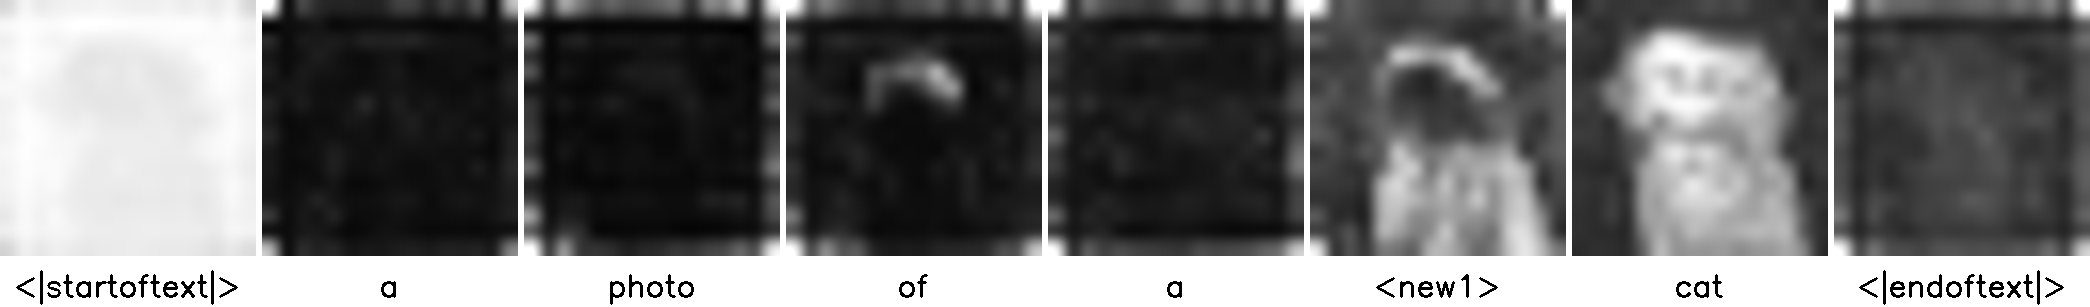

In [4]:
prompts = ["A photo of a dog",
           "A photo of a <new1> cat"]

NUM_DIFFUSION_STEPS = 50
source_subject_word = 'dog'
target_subject_word = '<new1>'

source_substruct_words = 'pot'
target_substruct_words = '<new2>'

# source_subject_word = 'dog'
# target_subject_word = '<new1>'

# 如果需要多概念编辑，则需要额外再指定一些词 不然就是None
# sustract_words = (((source_substruct_words,), (target_substruct_words,)))
sustract_words = None
controller = AttentionSwap(prompts, NUM_DIFFUSION_STEPS, 
                            cross_map_replace_steps=.7,
                            self_map_replace_steps=.3,
                            self_output_replace_steps=.2,
                            tokenizer=pipe.tokenizer,
                            device=pipe.device,
                            source_subject_word=source_subject_word, 
                            target_subject_word=target_subject_word,
                            substruct_words=sustract_words,
                            )

outputs = pipe(prompt=prompts, height=512, width=512, num_inference_steps=NUM_DIFFUSION_STEPS,
                controller=controller, generator=g_cpu, guidance_scale = 6.0, ModelPath = custom_path)

view_images( [np.array(img) for img in outputs.images] )

pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=0)
pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=1)



## p2p + DreamBooth

In [5]:
from pipeline_prompt2prompt import Prompt2PromptPipeline
from ptp_utils import AttentionStore, AttentionReplace, LocalBlend, AttentionRefine, AttentionReweight, view_images, get_equalizer

In [6]:
#g_cpu = torch.Generator().manual_seed(2333)
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')
pipe = Prompt2PromptPipeline.from_pretrained(model_path).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, -1), (6, -1), (7, -1), (8, -1), (9, 5), (10, 6)]


  0%|          | 0/50 [00:00<?, ?it/s]

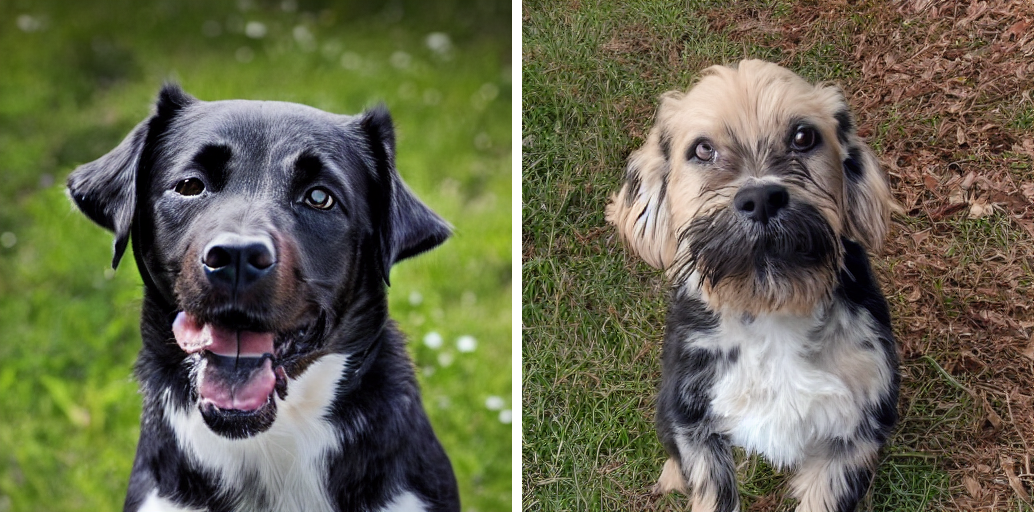

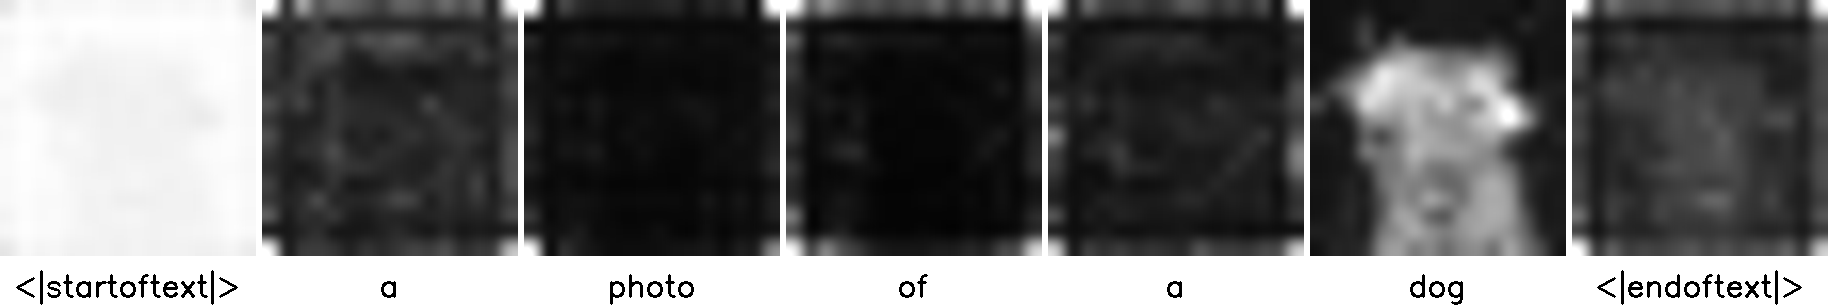

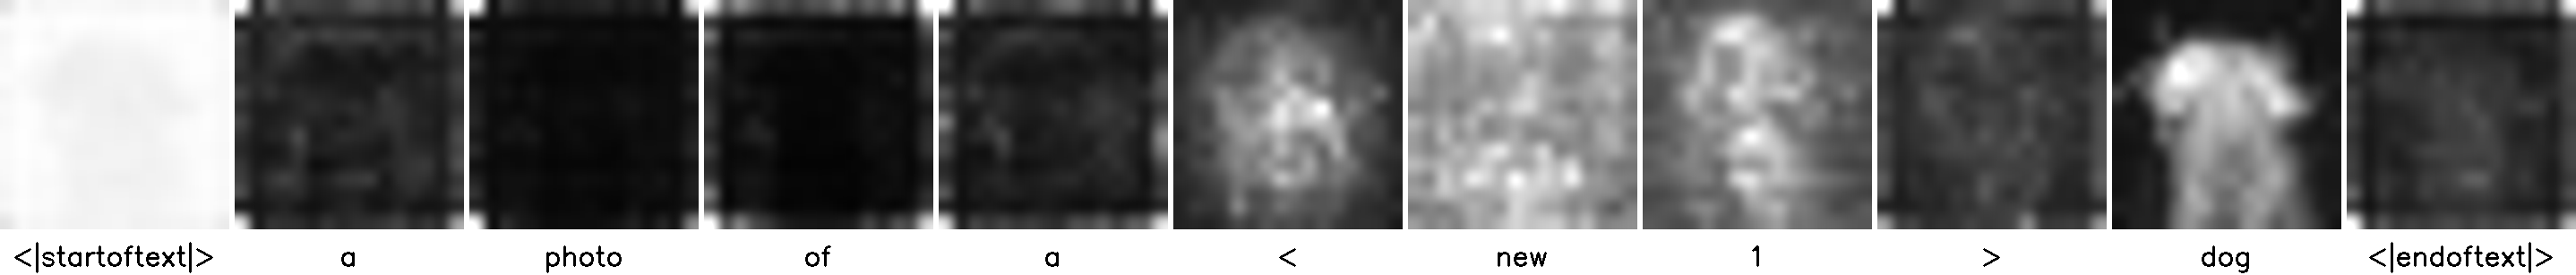

In [9]:
prompts = ["A photo of a dog",
           "A photo of a <new1> dog"]

NUM_DIFFUSION_STEPS = 50
lb = LocalBlend(prompts, ("dog", "dog"),tokenizer=pipe.tokenizer, device=pipe.device)   # only change the local squirrel
controller = AttentionRefine(prompts, NUM_DIFFUSION_STEPS, 
                            cross_replace_steps=.7,
                            self_replace_steps=.3,
                            tokenizer=pipe.tokenizer,
                            device=pipe.device,)
g_cpu = torch.Generator().manual_seed(5837)
outputs = pipe(prompt=prompts, height=512, width=512, num_inference_steps=NUM_DIFFUSION_STEPS,
                controller=controller, generator=g_cpu,)
view_images( [np.array(img) for img in outputs.images] )
pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=0)
pipe.show_cross_attention(prompts, controller, res=16, from_where=("up", "down"), select=1)